In [39]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
from typing import Any
from copy import copy
from anndata import AnnData
import scipy.sparse as sp
from cellrank.tl.kernels import VelocityKernel
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
adata = scv.read('../../out/RPM-time-series/adata_03bwvl.h5ad') #This is the adata with velocity calculated already

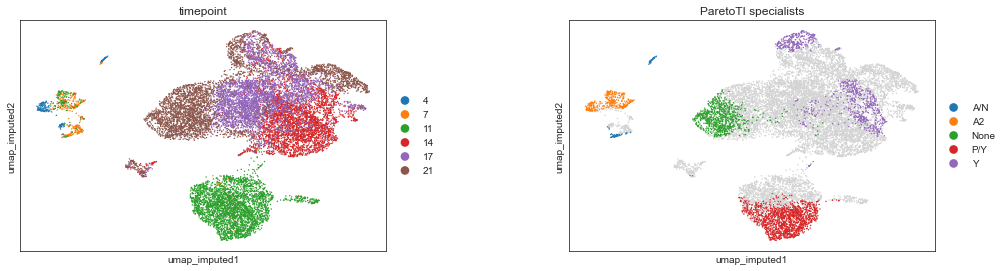

In [4]:
sc.pl.scatter(adata, basis = 'umap_imputed', color = ['timepoint','ParetoTI_specialists']) #make sure umaps look correct before moving forward for timepoints and archetypes

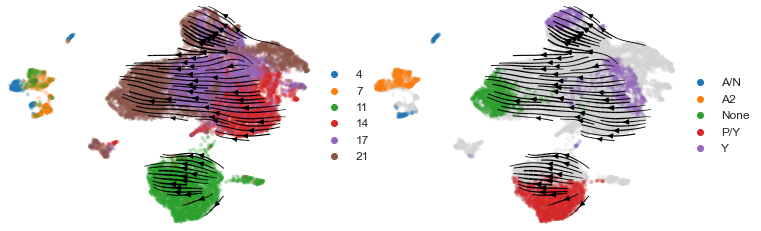

In [5]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap_imputed", color = ['timepoint', 'ParetoTI_specialists'], legend_fontsize=12, title="", smooth=0.8, min_mass=4, 
    legend_loc = 'on right')

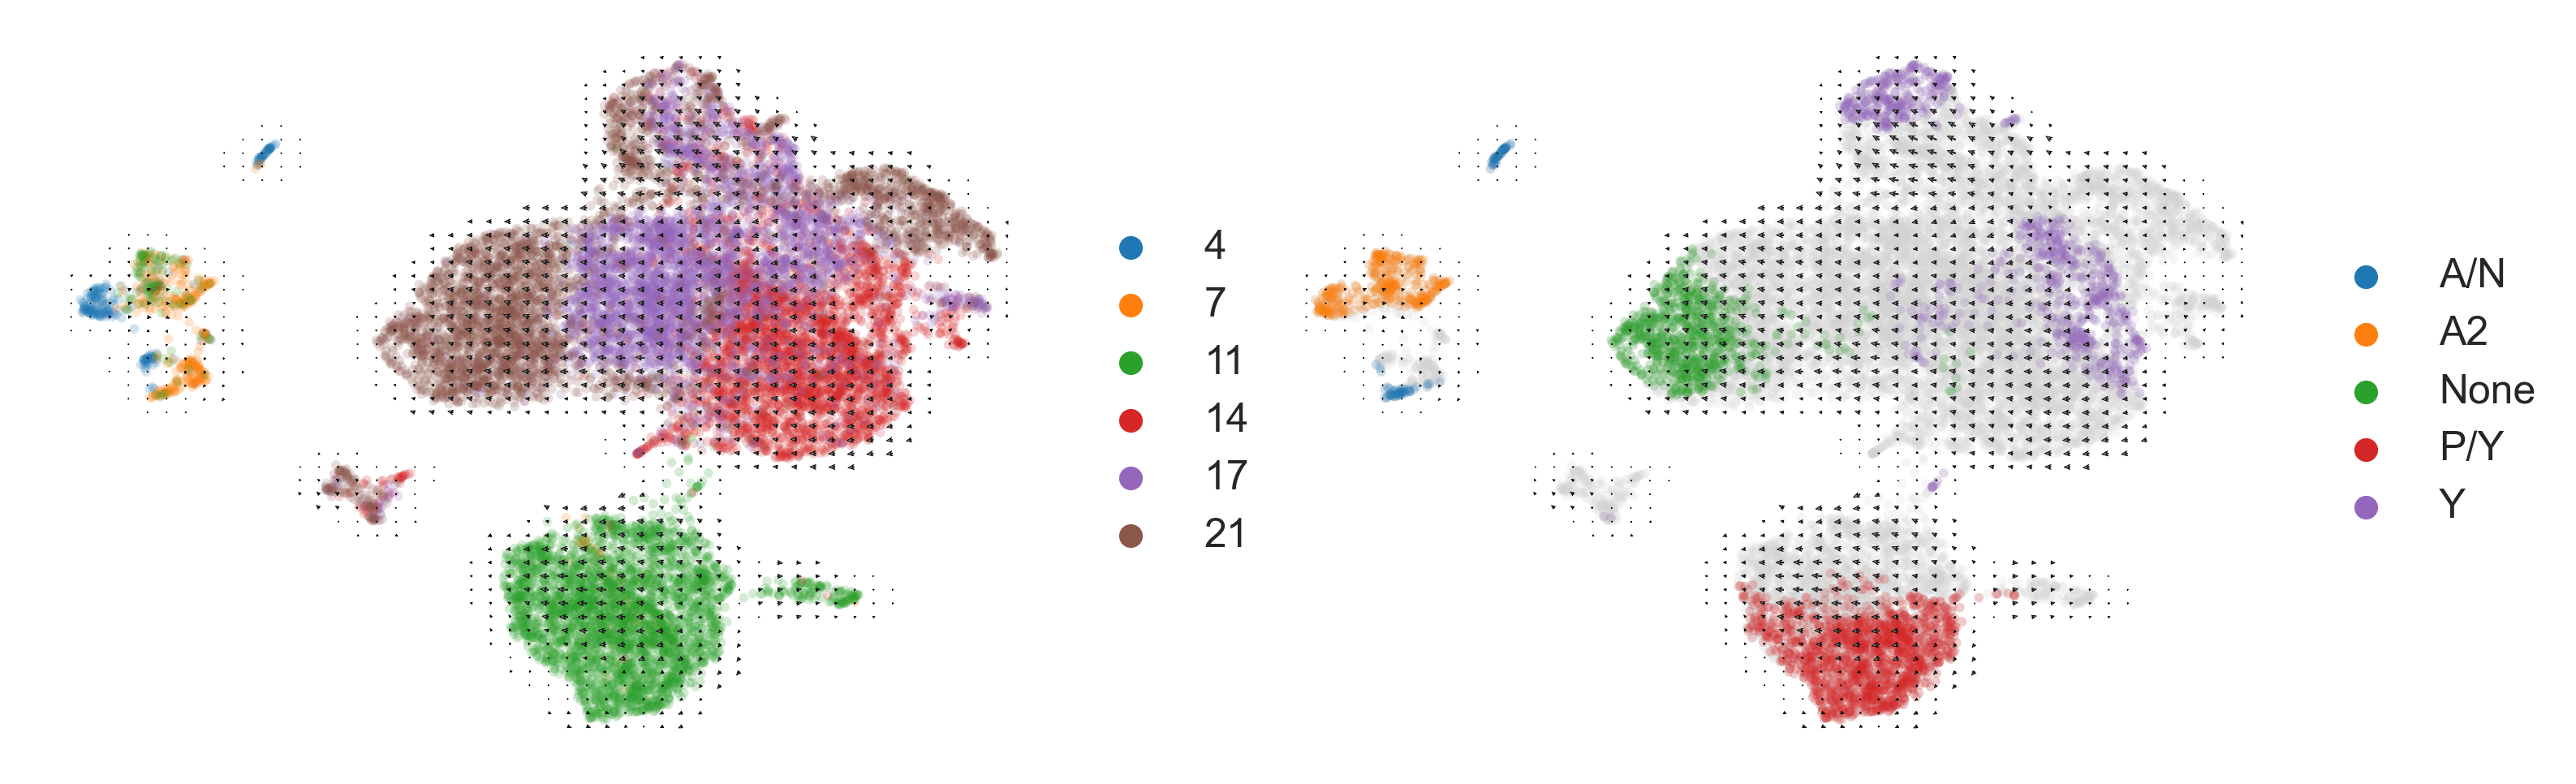

In [80]:
scv.pl.velocity_embedding_grid(
    adata, basis="umap_imputed", color = ['timepoint', 'ParetoTI_specialists'], legend_fontsize=12, title="", smooth=0.8, dpi = 300, legend_loc = 'on right')

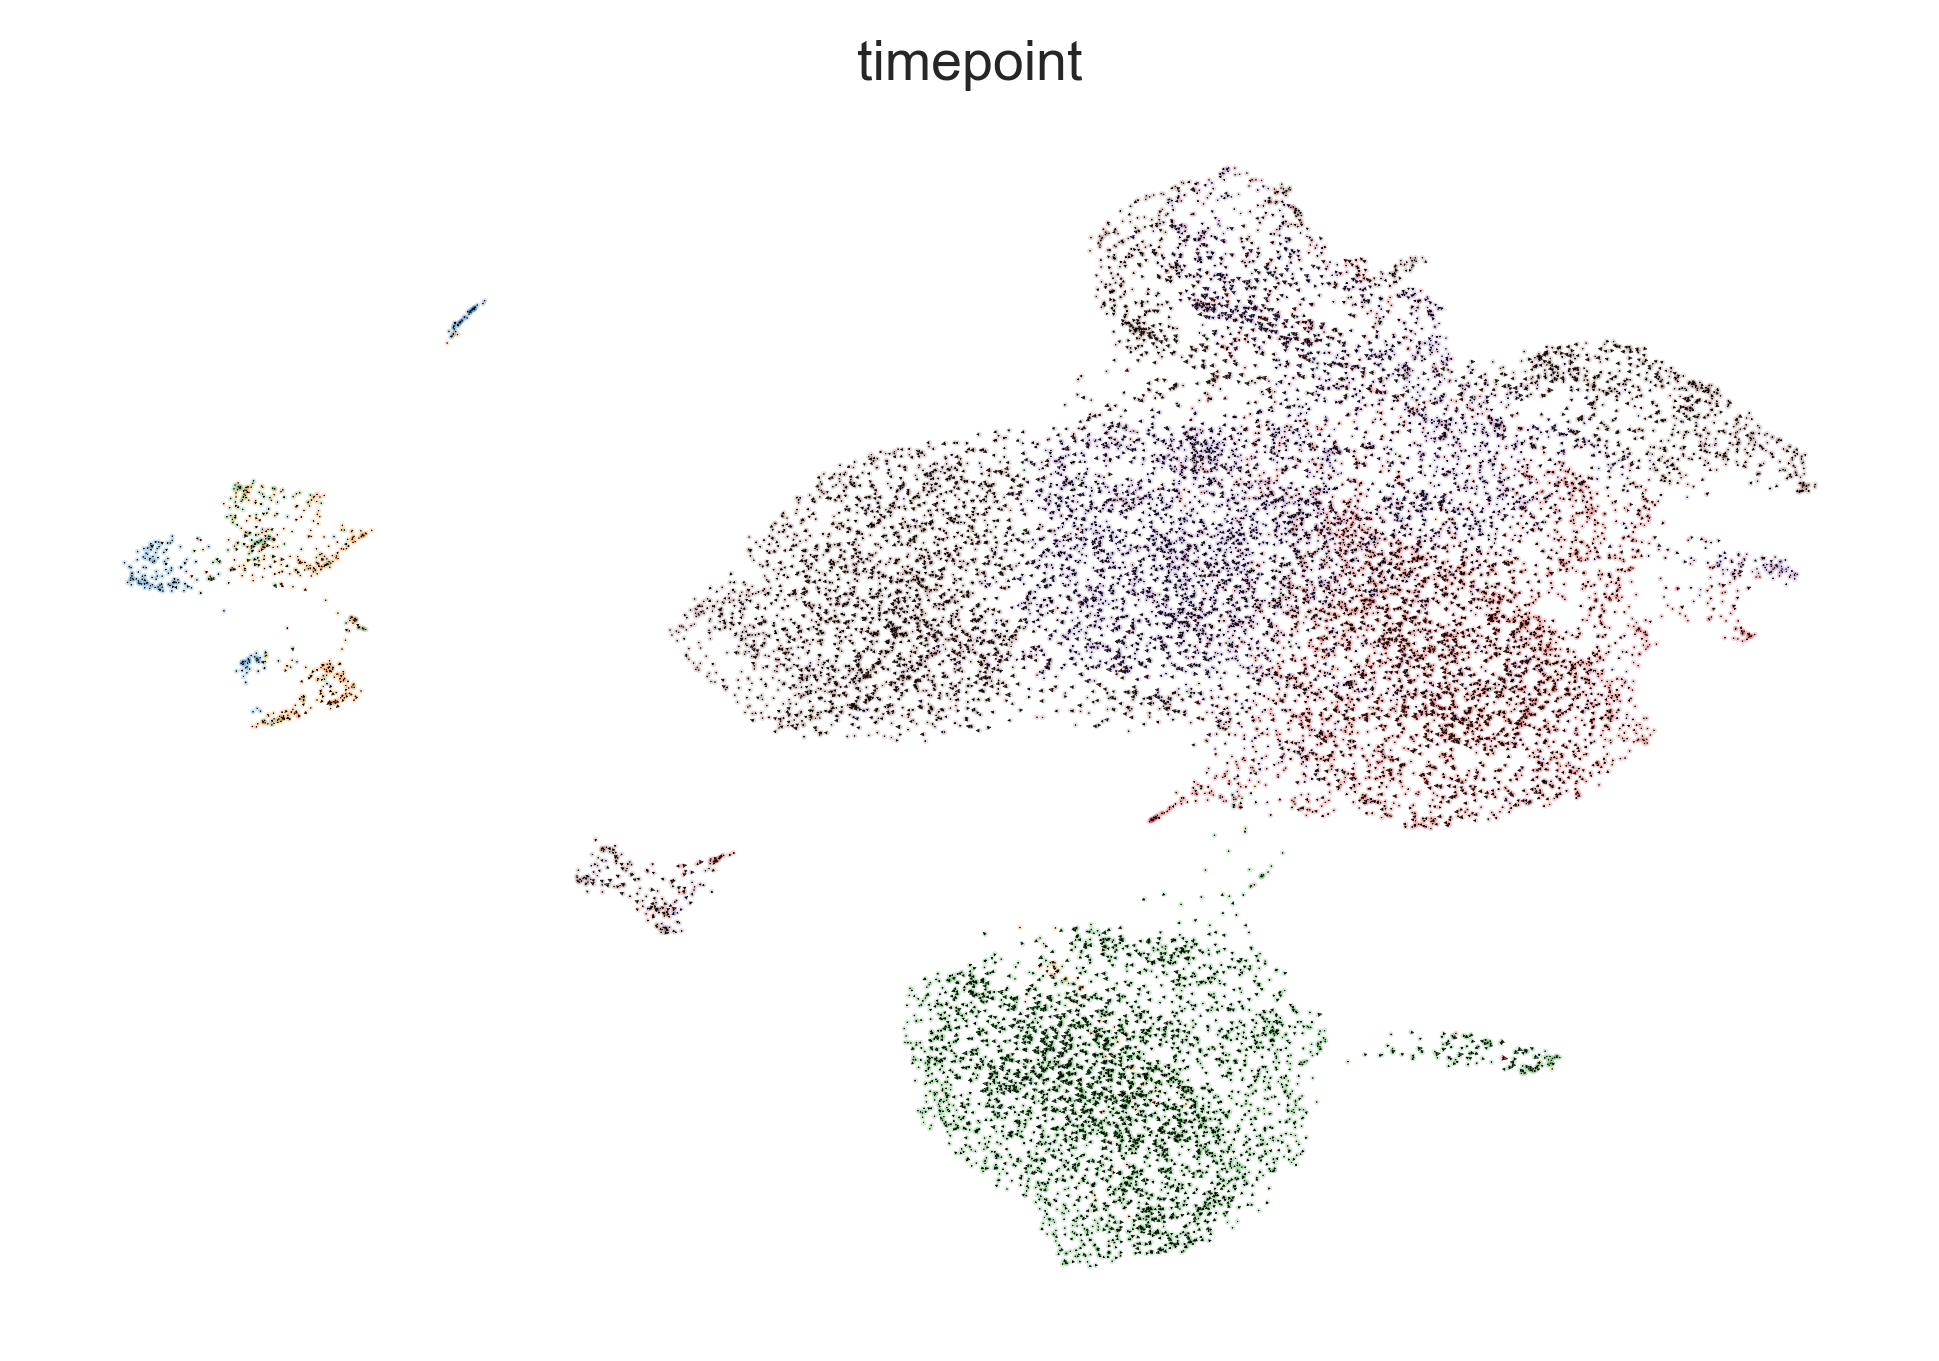

In [124]:
scv.pl.velocity_embedding(adata, color = 'timepoint', basis = 'umap_imputed', dpi = 400)

In [6]:
class MyKernel(cr.tl.kernels.Kernel):
    def __init__(
        self, adata: AnnData, obs_key: str = "Diffusion Pseudotime", **kwargs: Any
    ):
        super().__init__(adata=adata, obs_key=obs_key, **kwargs)

    def _read_from_adata(self, obs_key: str, **kwargs: Any) -> None:
        super()._read_from_adata(**kwargs)

        print(f"Reading `adata.obs[{obs_key!r}]`")
        self.pseudotime = self.adata.obs[obs_key].values

    def compute_transition_matrix(self, some_parameter: float = 0.5) -> "MyKernel":
        print("Accessing `.pseudotime`: ", self.pseudotime)
        transition_matrix = sp.diags(
            (some_parameter,) * len(self.adata), dtype=np.float64
        )

        self._compute_transition_matrix(transition_matrix)

        return self

    def copy(self) -> "MyKernel":
        return copy(self)

In [7]:
k = MyKernel(adata).compute_transition_matrix()
k.compute_transition_matrix()

Reading `adata.obs['Diffusion Pseudotime']`
Accessing `.pseudotime`:  [0.08062416 0.07080161 0.0694875  ... 0.13437028 0.12651777 0.10692273]
Accessing `.pseudotime`:  [0.08062416 0.07080161 0.0694875  ... 0.13437028 0.12651777 0.10692273]


<MyKernel>

In [8]:
vk = VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/15138 [00:00<?, ?cell/s]

  0%|          | 0/15138 [00:00<?, ?cell/s]

<VelocityKernel>

In [23]:
combined_kernel = 0.35 * vk + 0.65* k

In [24]:
from cellrank.tl.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[n=15138, kernel=((0.35 * <VelocityKernel[softmax_scale=6.5, mode=deterministic, seed=2732, scheme=<CorrelationScheme>]>) + (0.65 * <MyKernel>))]


In [25]:
g.compute_schur(n_components=20)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000120e+00 -1.1639969796830470e-04 -9.5221837599112724e-04 2.9232634952012474e-03 -1.2931017839947260e-03 -3.1569482248906540e-03 2.2009262761692446e-04 2.0895145549444334e-02 1.0671946073807032e-02 -1.7867445666968129e-02 9.6184984452626944e-03 -5.3411806373200969e-03 -1.3453904864726349e-02 8.0528578604552557e-03 2.6213236819940516e-03 -4.3051776741461819e-03 8.2410275868748661e-03 1.4143927540611554e-02 -1.1625863387546138e-02 -2.6501232558954146e-02 9.0951860801411523e-03 
0.0000000000000000e+00 9.9927043434947882e-01 -3.0434539909882397e-05 -1.9887601716442244e-03 3.9659314143353497e-03 -2.5342296788847684e-06 -1.1228288697644213e-03 1.0348510034260868e-02 -1.2256833940485063e-03 -7.7527977217451008e-03 6.5655867304958565e-03 -2.0942550543992717e-03 -2.9707914272030403e-03 2.7899585036922862e-03 3.9140885216424354e-03 -1.6778204204994593e-03 -8.8446412527742983e-03 1.2120922663396740e-02 -5.6154958746001430e-03 -2.7178454238

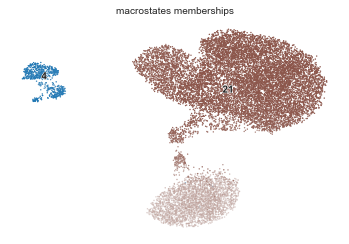

In [30]:
g.compute_macrostates(cluster_key="timepoint") 
g.plot_macrostates()

In [31]:
g.compute_terminal_states() 

In [32]:
g.compute_absorption_probabilities(solver="gmres", use_petsc=True)

  0%|          | 0/2 [00:00<?, ?/s]

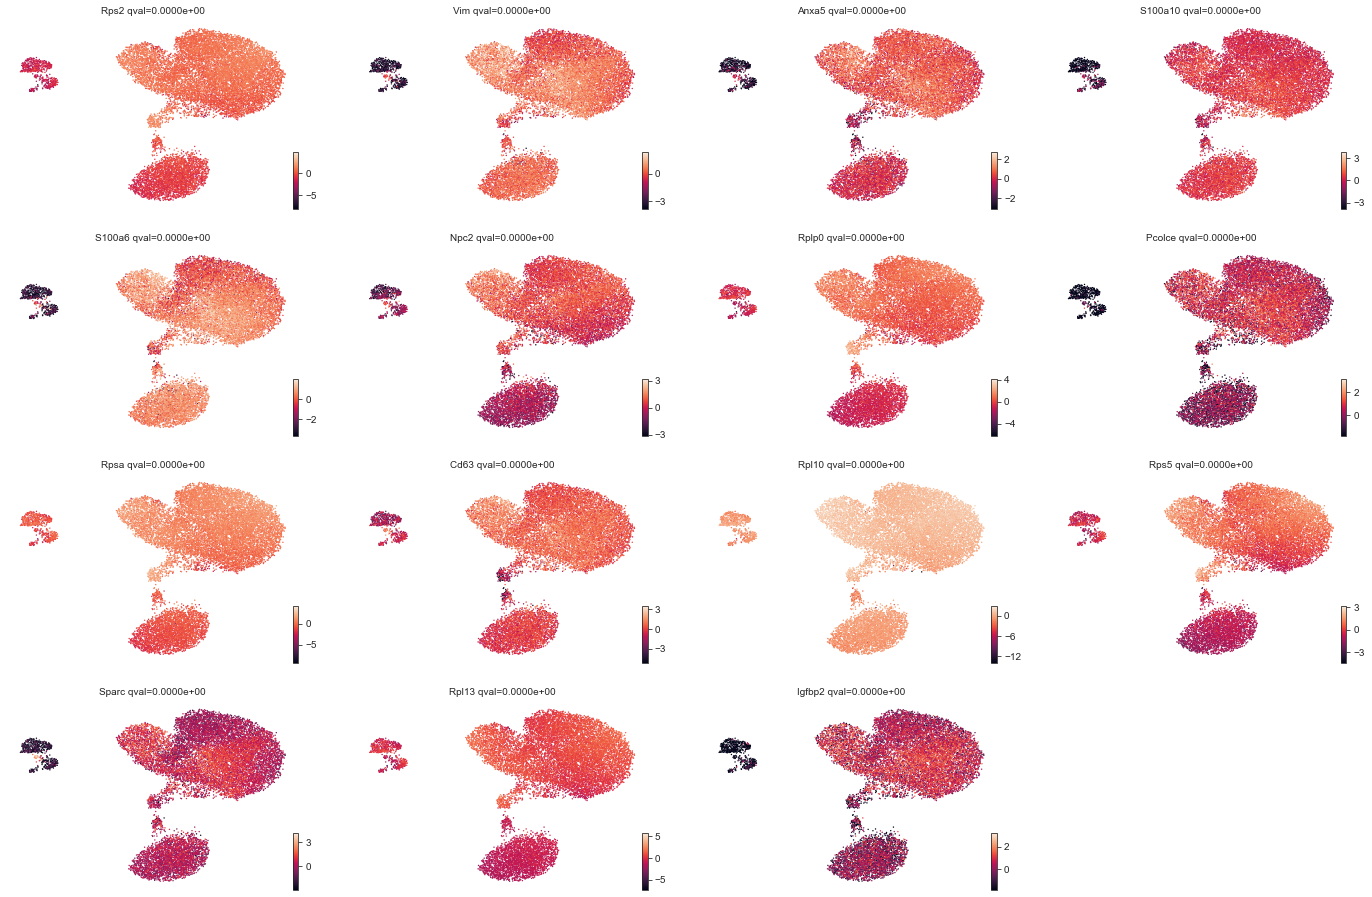

In [33]:
dayterm_drivers = g.compute_lineage_drivers(lineages="21", return_drivers=True) #when running macrostates and terminal states by archetype
dayterm_drivers.sort_values(by="21_corr", ascending=False)
g.plot_lineage_drivers("21", n_genes=15)

In [104]:
adata.obs['velocity_pseudotime'] = adata.obs['Diffusion Pseudotime']

In [107]:
scv.tl.paga(
    adata,
    groups="timepoint",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="Diffusion Pseudotime",
)

running PAGA using priors: ['Diffusion Pseudotime', 'terminal_states_probs']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


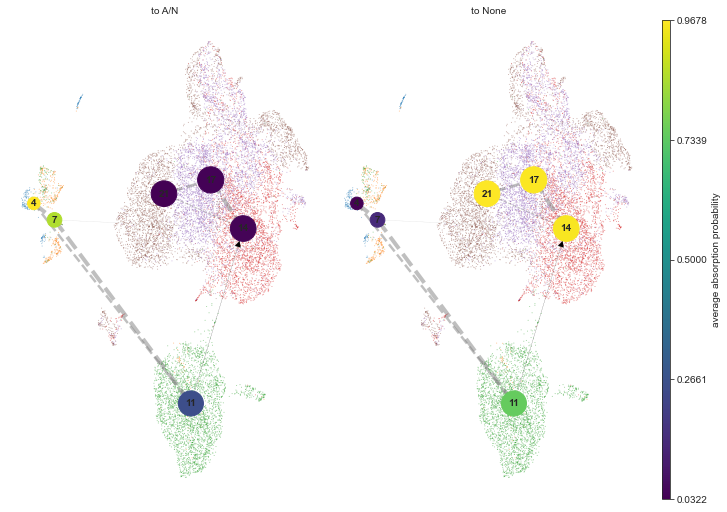

In [ ]:
cr.pl.cluster_fates(
    adata,
    mode="paga",
    cluster_key="timepoint",
    basis="umap_imputed",
    legend_kwargs={"loc": "top right out"},
    legend_loc="on data",
    node_size_scale=4,
    edge_width_scale=1,
    max_edge_width=4,
    title="Directed PAGA",figsize = (10, 7))#, save = 'paga_timepoint.pdf')

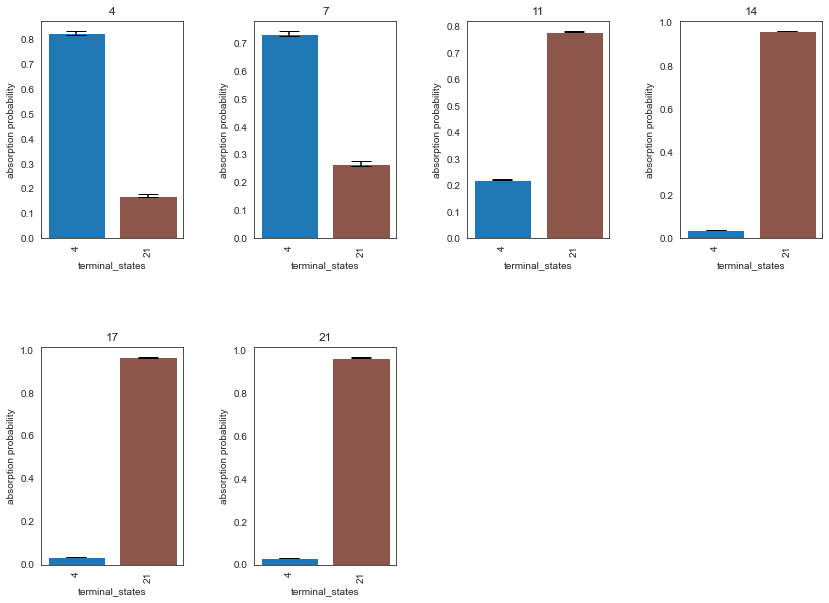

In [38]:
cr.pl.cluster_fates(
    adata,
    mode="bar",
    cluster_key="timepoint",
    basis="umap_imputed") #, save = 'paga_bar_timepoint.pdf'


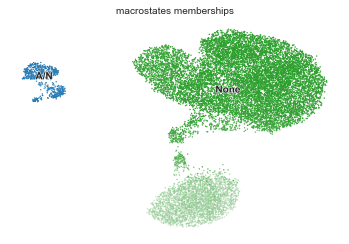

In [82]:
g.compute_macrostates(cluster_key="ParetoTI_specialists") #to change macrostates calcualted by archetype
g.plot_macrostates()

In [83]:
g.compute_terminal_states() 

In [84]:
g.compute_absorption_probabilities(solver="gmres", use_petsc=True)

  0%|          | 0/2 [00:00<?, ?/s]

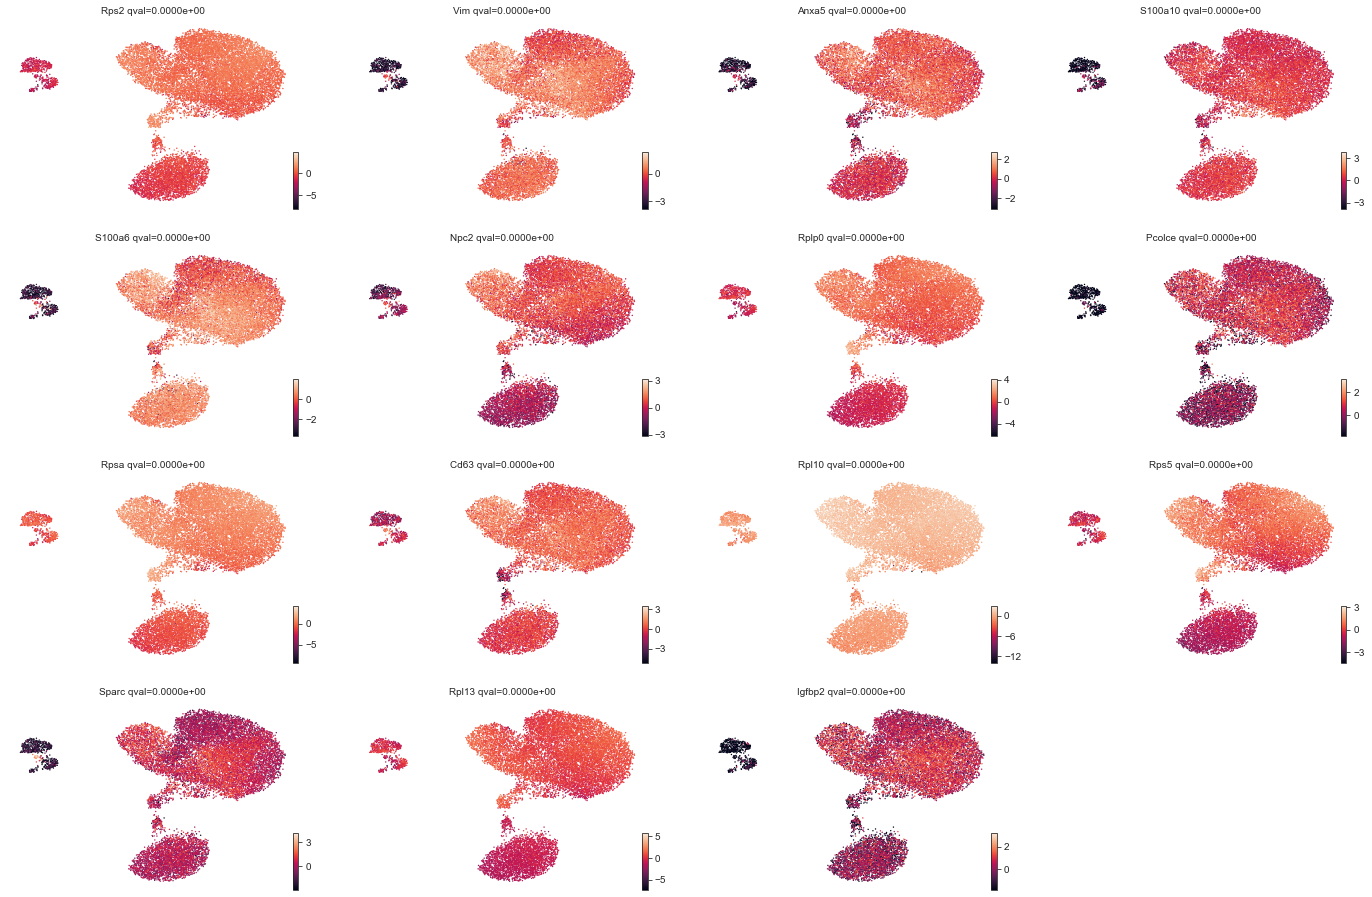

In [85]:
day21_drivers = g.compute_lineage_drivers(lineages="None", return_drivers=True)  #when running macrostates and terminal states by timepoint
day21_drivers.sort_values(by="None_corr", ascending=False)
g.plot_lineage_drivers("None", n_genes=15)

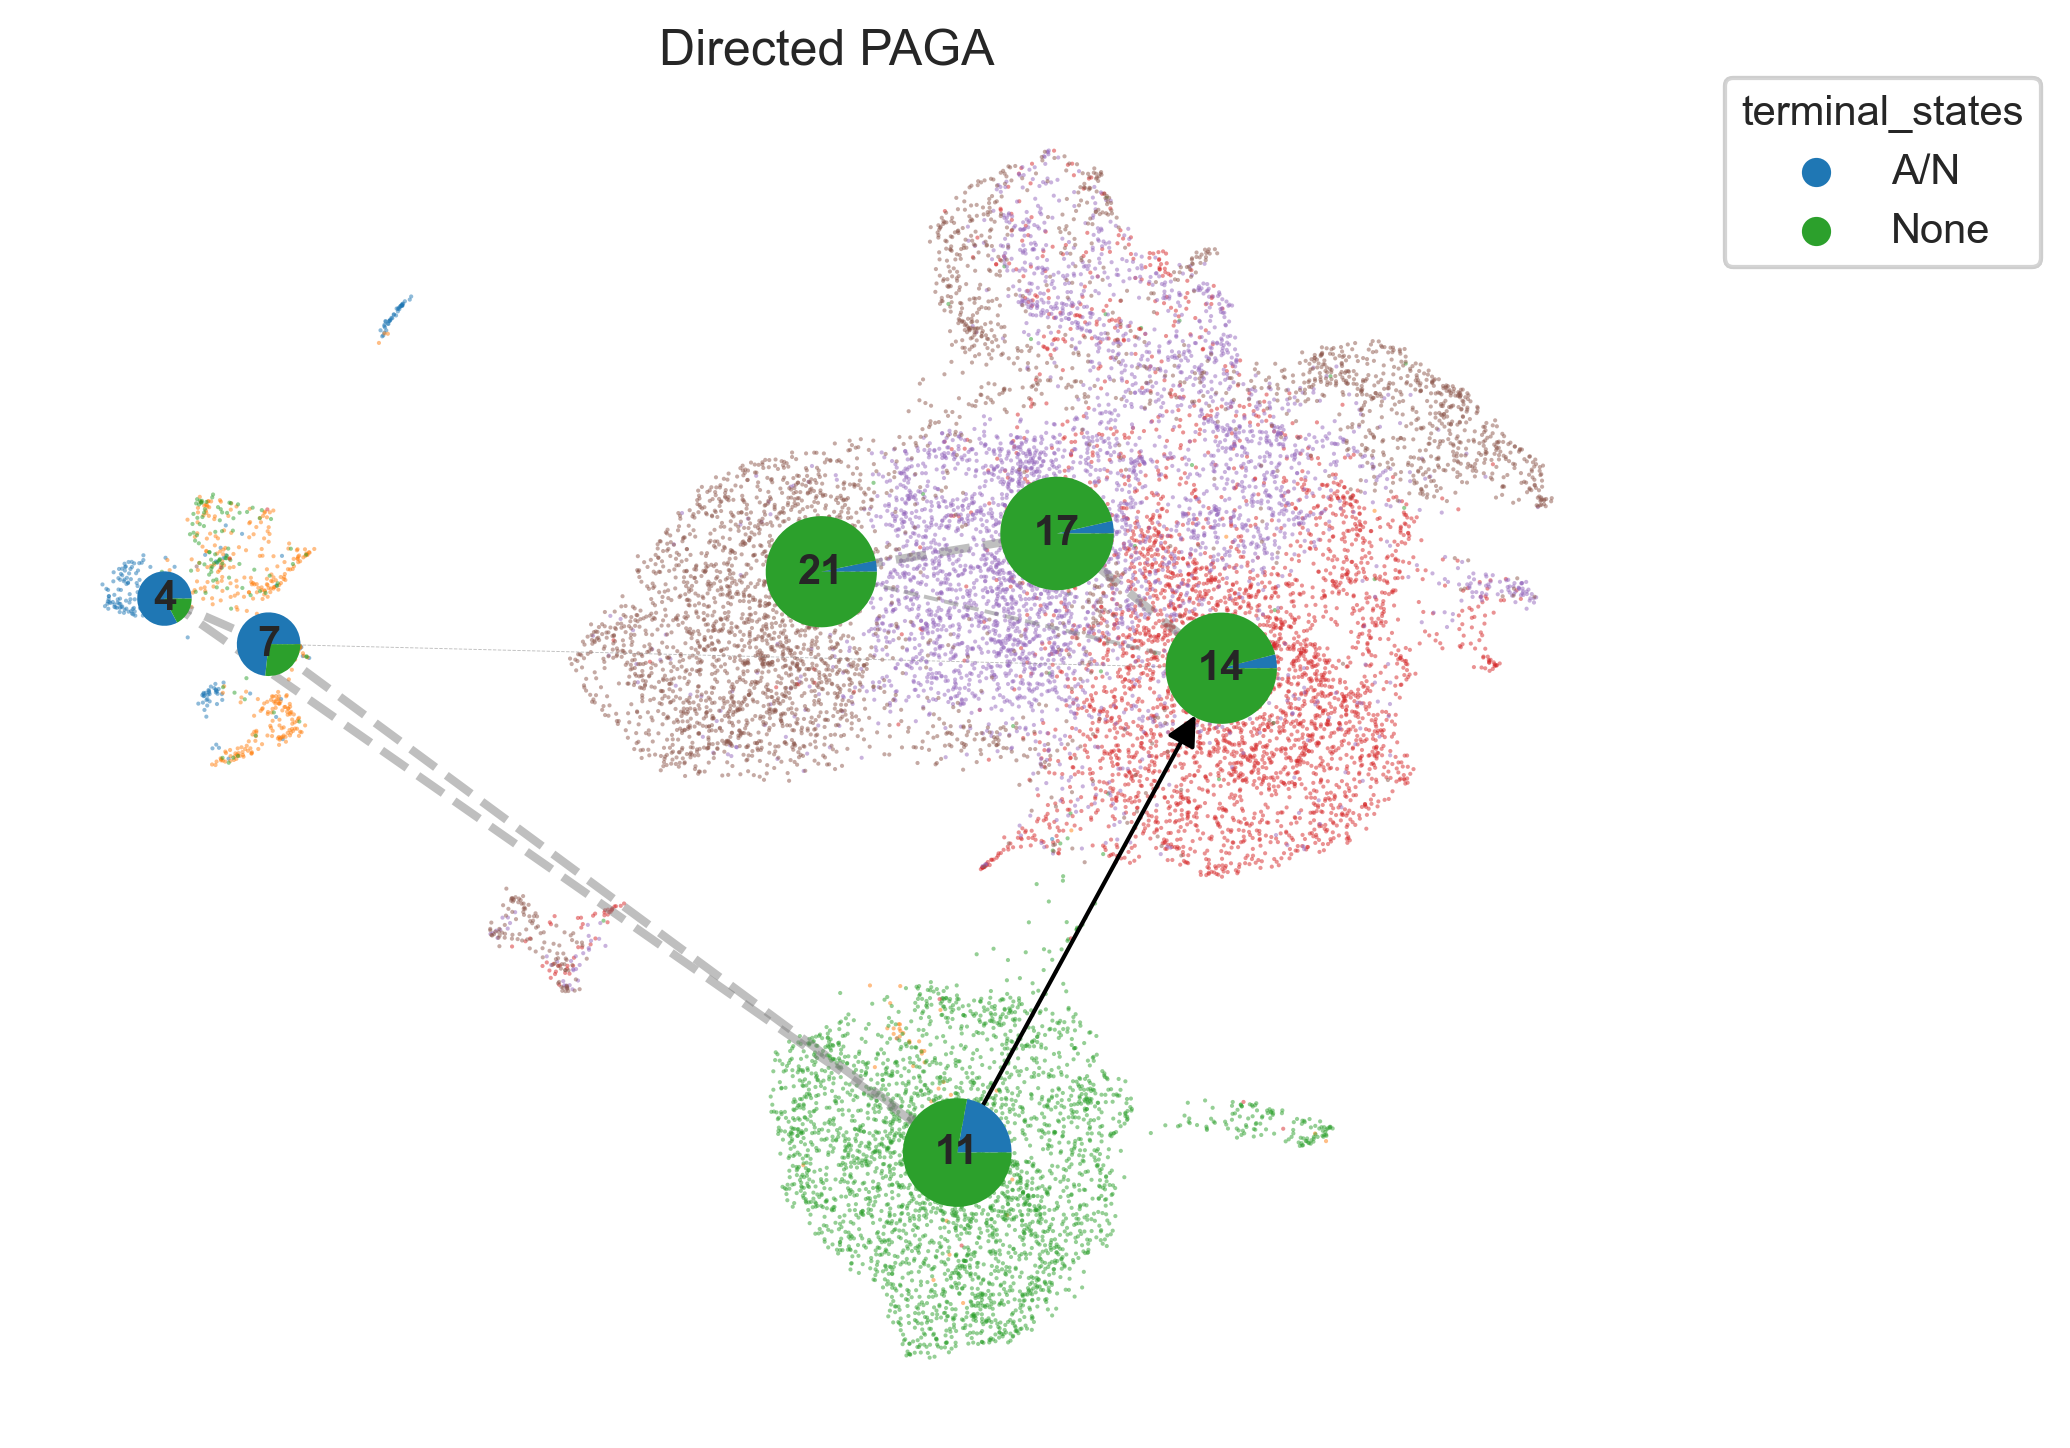

In [99]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="timepoint",
    basis="umap_imputed",
    legend_kwargs={"loc": "top right out"},
    legend_loc="on data",
    node_size_scale=4,
    edge_width_scale=1,
    min_edge_width=1,
    dpi = 300,
    title="Directed PAGA",figsize = (6, 5))#, save = 'paga_timepoint.pdf')

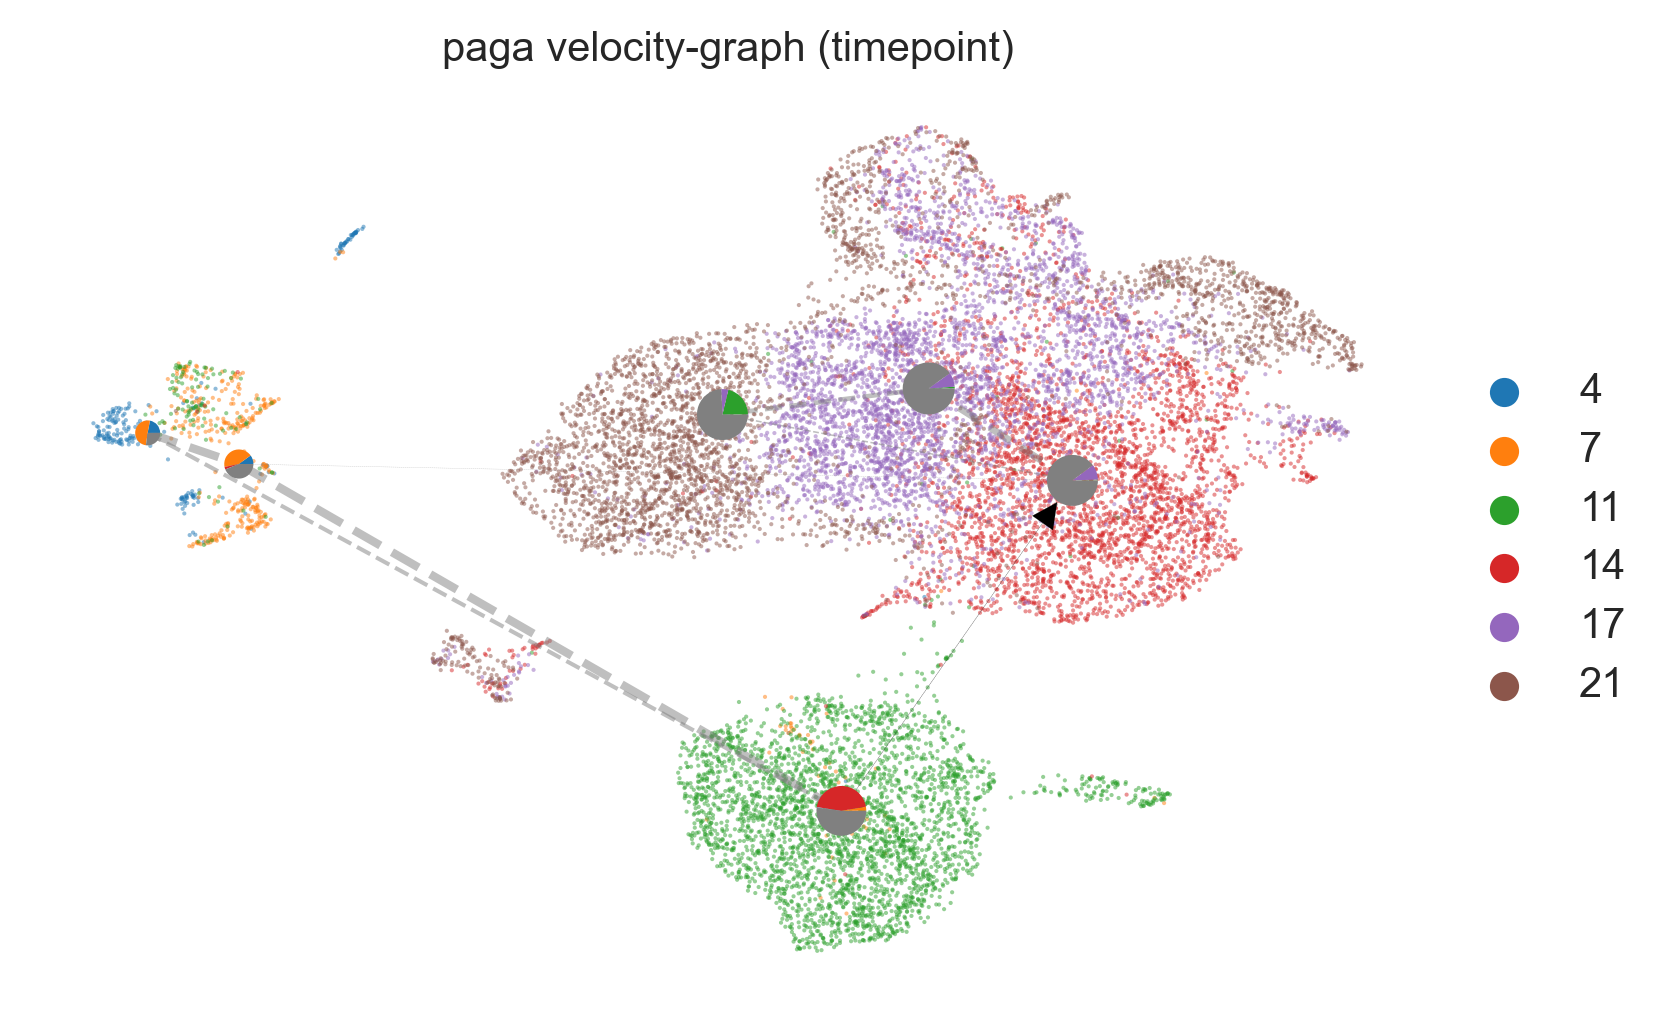

In [113]:
import seaborn as sns
scv.pl.paga(adata,  color = 'ParetoTI_specialists',basis = 'umap_imputed', dpi = 300
           )


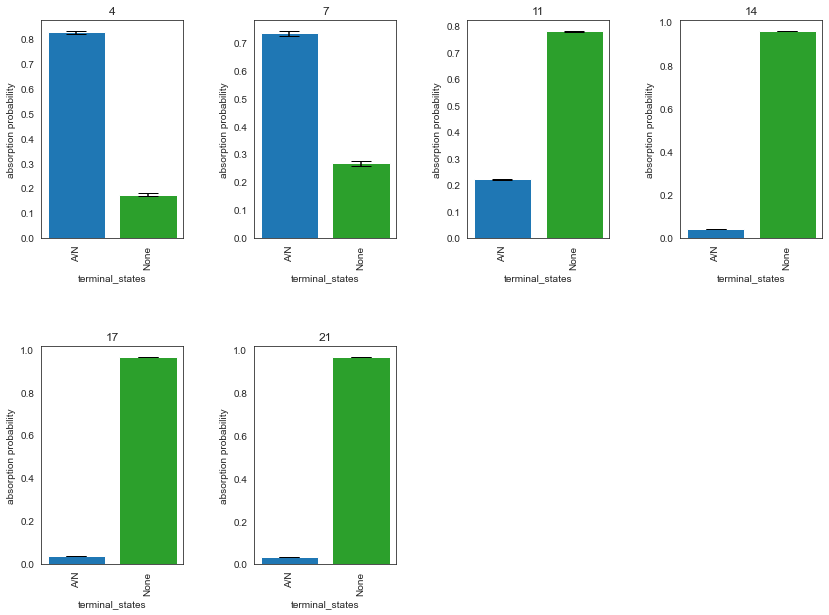

In [88]:
cr.pl.cluster_fates(
    adata,
    mode="bar",
    cluster_key="timepoint",
    basis="umap_imputed") #, save = 'paga_bar_timepoint.pdf'


  0%|          | 0/2 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

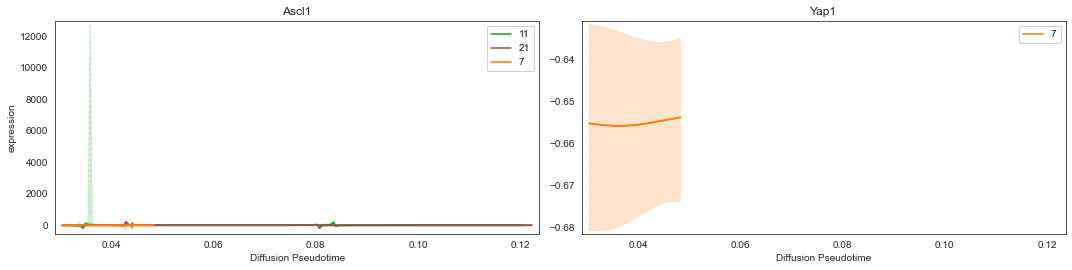

In [64]:
model = cr.ul.models.GAM(adata, link = 'inverse')
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    genes=["Ascl1", "Yap1"],
    ncols=3,
    time_key="Diffusion Pseudotime",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

  0%|          | 0/1 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

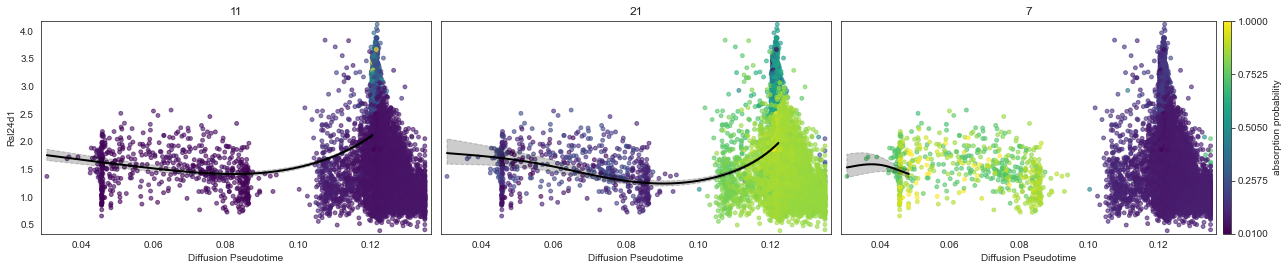

In [69]:
cr.pl.gene_trends(
    adata,
    model,
    ["Rsl24d1"],
    data_key="Ms",
    time_key="Diffusion Pseudotime",
    show_progress_bar=False,
)

  0%|          | 0/15 [00:00<?, ?gene/s]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

21
0          Slco5a1
1       AC149090.1
2             Xkr4
3            Ncoa2
4           Vcpip1
5            Vamp7
6           Mrpl15
7            Tram1
8             Rpl7
9            Cops5
10         Arfgef1
11           Snhg6
12  CAAA01118383.1
13          Lactb2

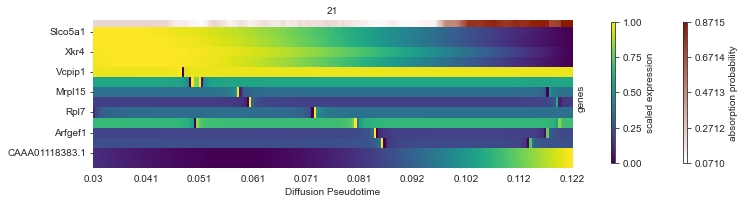

In [68]:
genes = cr.pl.heatmap(
    adata,
    model,
    adata.var_names[:15],
    time_key="Diffusion Pseudotime",
    lineages="21",
    show_absorption_probabilities=True,
    show_progress_bar=False,
    return_genes=True,
)
genes

# Alignment with archetype space

In [125]:
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
def fit_bulk_pca(adata_var_names, species = 'human'):
    bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
    bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH10','MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14','SEPT1', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]    
    if species == 'mouse':
        bulk.index = [i.capitalize() for i in bulk.index]
    shared_genes = sorted(list(set(adata_var_names).intersection(bulk.index)))
        
    bulk = bulk.loc[shared_genes]
    bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
    # bulk = bulk / np.linalg.norm(bulk, axis=0)

    pca = PCA(n_components=20)
    data_pca = pca.fit_transform(bulk.T)
    pca_df = pd.DataFrame(data_pca)
    
    arc = pd.read_csv('../../../data/bulk-rna-seq/arc_gene_space_no_lowgenes-10-21-20.csv', header = None, index_col = None)
    arc_genes = pd.read_csv('../../../data/bulk-rna-seq/geneNames_wo_lowgenes.csv', header = None, index_col = None)
    arc.columns = arc_genes[0]
    arc = arc.T
    arc.columns = ['SCLC-Y','SCLC-P','SCLC-N', 'SCLC-A2', 'SCLC-A']
    if species == 'mouse':
        arc.index = [i.capitalize() for i in arc.index]
    arc = arc.loc[shared_genes]
    arc = pd.DataFrame(pp.scale(arc), columns = arc.columns, index = arc.index)

    # arc = arc / np.linalg.norm(arc, axis=0)

    arc_pca = pca.transform(arc.T)
    arc_pca_df = pd.DataFrame(arc_pca, index=arc.columns)
    arc_pca_df['color'] = arc.columns
    
    return pca, pca_df, arc_pca_df, shared_genes

In [173]:
def transform_data(adata, pca, shared_genes, layer = 'X', species = 'human'):
    if species == 'mouse':
        shared_genes = [i.capitalize() for i in shared_genes]
    tmp = adata[:,shared_genes].copy()
    if layer == 'X':
        adata_df = pd.DataFrame(tmp.X, index=tmp.obs_names, columns=tmp.var_names)
    else:
        adata_df = pd.DataFrame(tmp.layers[layer], index=tmp.obs_names, columns=tmp.var_names)
        adata_df = adata_df.fillna(0)

    adata_df = adata_df.T
    adata_df = pd.DataFrame(pp.scale(adata_df), columns = adata_df.columns, index = adata_df.index)

    # adata_df = adata_df / np.linalg.norm(adata_df, axis=0)

    adata_pca = pca.transform(adata_df.T)
    adata_pca_df = pd.DataFrame(adata_pca, index=adata_df.columns)
    tot_var_full = adata_df.T.var().sum()
    varexpl = adata_pca_df.var() #var explained by bulk PCA
    return adata_df, adata_pca_df, {'tot_var_full':tot_var_full, 'varexpl':varexpl}


In [127]:
X_norm = sc.pp.normalize_total(adata, layer='matrix', inplace = False)['X']
adata.layers["norm_counts"] = X_norm


adata.layers['log1p_norm_unscaled'] = np.log1p(adata.layers["norm_counts"])


hvgs = sc.pp.highly_variable_genes(adata, layer='log1p_norm_unscaled', inplace=False)

hvgs.index = adata.var_names

pca, pca_df, arc_pca_df, shared_genes = fit_bulk_pca(hvgs.loc[hvgs.highly_variable==True].index, species='mouse')

In [128]:
adata_df_hvgs, adata_pca_df_hvgs, adata_var_dict_hvgs = transform_data(adata, pca, shared_genes, layer='log1p_norm_unscaled', species='mouse')

<AxesSubplot:xlabel='0', ylabel='1'>

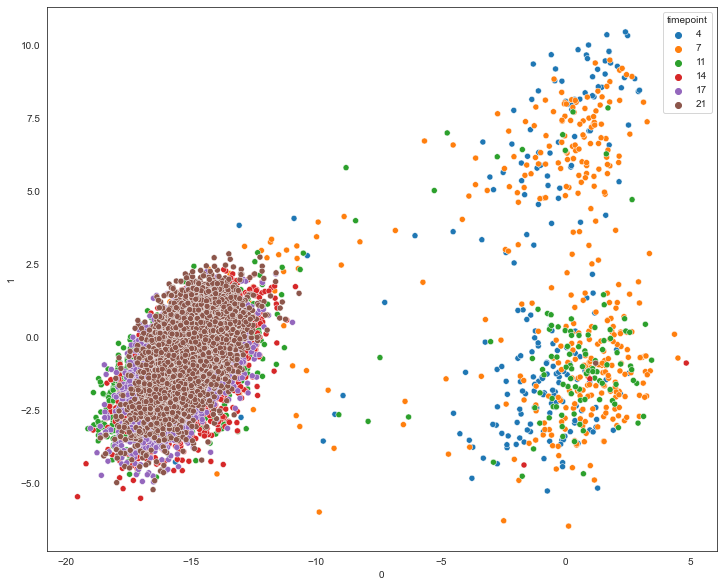

In [130]:
plt.figure(figsize = (12,10))
sns.scatterplot(-adata_pca_df_hvgs[0], adata_pca_df_hvgs[1], hue =  adata.obs['timepoint'])


In [142]:
adata.obsm['X_pca_bulk'] = np.array(adata_pca_df_hvgs[[0,1]])

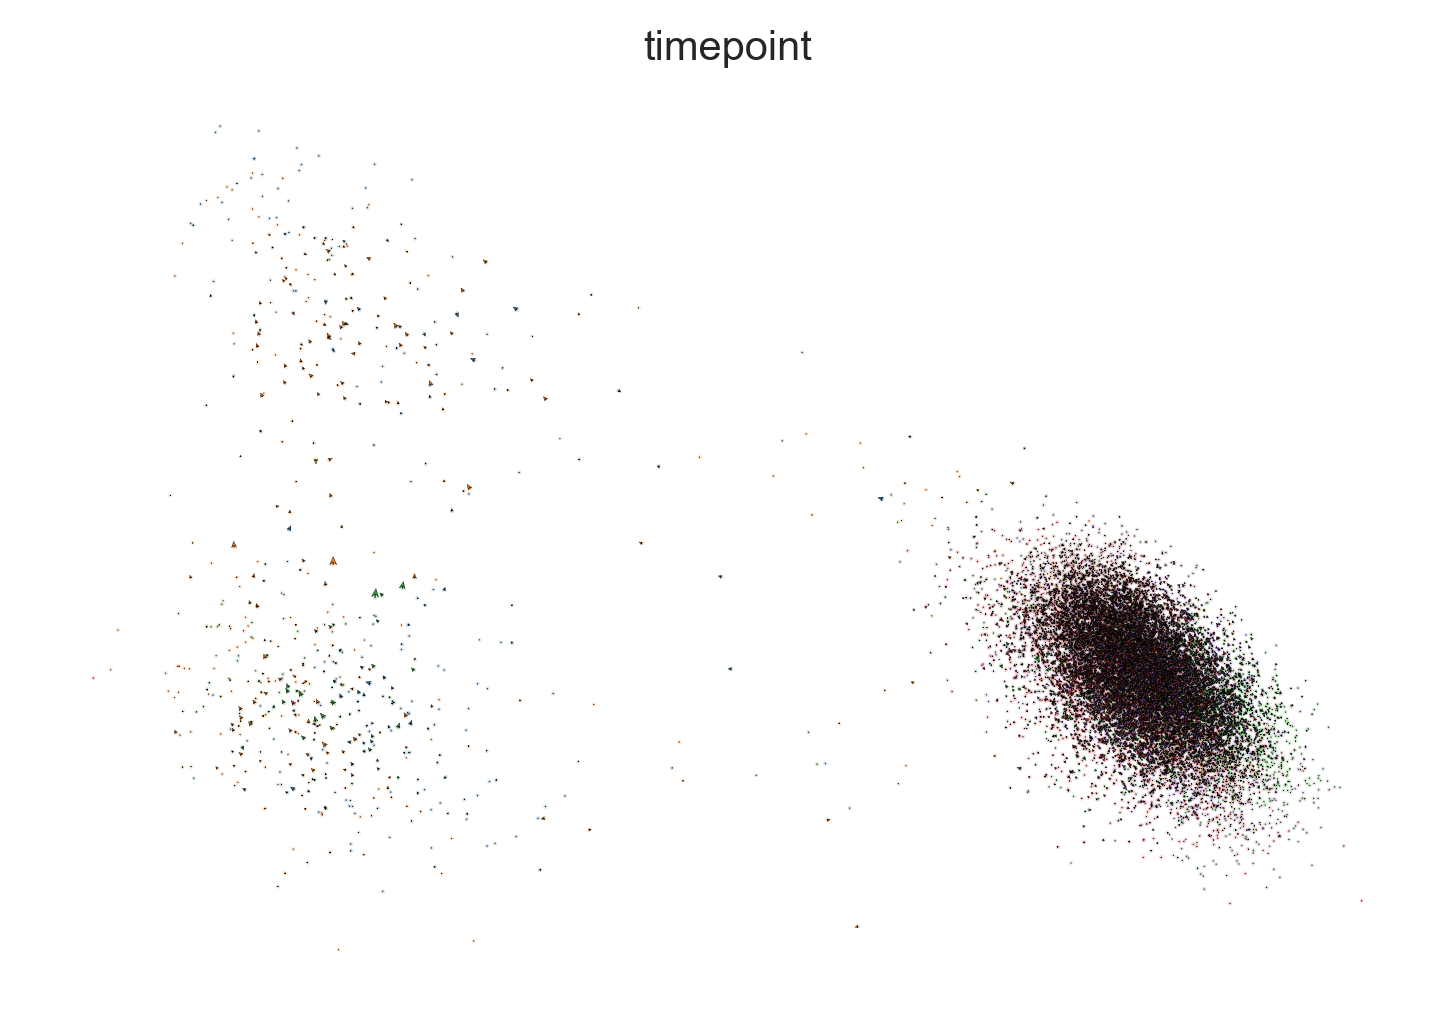

In [145]:
scv.pl.velocity_embedding(adata, basis = 'pca_bulk', color = 'timepoint', dpi = 300)

In [151]:
vel = pd.DataFrame(adata.layers['velocity'], index=adata.obs_names, columns=adata.var_names)

In [165]:
vel.var().sort_values(ascending = False)

Gene
Spp1      5708.662288
Saa3      3464.799225
Col4a2    1753.447883
Ftl1       795.356227
Sftpa1     665.093207
             ...     
Cryab             NaN
Isl2              NaN
Ngp               NaN
Ltf               NaN
Cybb              NaN
Length: 10897, dtype: float64

In [162]:
vel_pca = pd.DataFrame(adata.obsm['velocity_pca_bulk'], index = adata.obs_names)

In [163]:
vel_pca.var()

0    0.000709
1    0.001001
dtype: float64

In [172]:
adata.layers['velocity']

array([[ 0.          ,  0.          ,  0.          , ...,  0.          ,
         0.          , -0.4663621855],
       [-0.3784593464, -0.4236679894, -0.6685602401, ...,  0.          ,
         0.          ,  0.3575556692],
       [-0.3770487526,  0.          ,  0.          , ...,  0.          ,
         0.          ,  0.1753526189],
       ...,
       [-0.4146161737, -0.3733756544, -0.7607118267, ...,  0.          ,
         0.5075570982, -0.2459042163],
       [-0.3871658644,  0.          ,  0.          , ...,  0.1355870011,
         0.520901426 , -0.2472778724],
       [ 0.          ,  0.          ,  0.          , ...,  0.          ,
         0.5211395567,  0.803108392 ]])

In [174]:
adata_df_hvgs_vel, adata_pca_df_hvgs_vel, adata_var_dict_hvgs_vel = transform_data(adata, pca, shared_genes,  species='mouse', layer = 'velocity')

<AxesSubplot:xlabel='0', ylabel='1'>

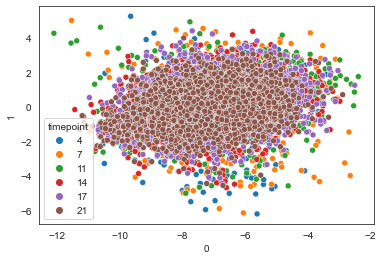

In [175]:
sns.scatterplot(-adata_pca_df_hvgs_vel[0], adata_pca_df_hvgs_vel[1], hue =  adata.obs['timepoint'])


In [176]:
df_rpmg = scv.get_df(adata, 'fit*', dropna=True) # had to run this first to get fit_alpha etc. to show
df_rpmg

fit_alpha  fit_beta  fit_gamma    fit_t_  fit_scaling  \
Gene                                                                    
CAAA01118383.1   1.431111  1.126073   0.545680  2.270933     1.069763   
Vamp7            1.436133  0.954271   0.424869  3.047110     0.941284   
AC149090.1       3.197476  1.805679   0.813160  1.516450     0.837968   
Xkr4             3.265963  0.614976   2.459040  0.812755     3.106336   
Mrpl15           1.555507  0.904461   0.352541  3.534340     0.865264   
...                   ...       ...        ...       ...          ...   
Trappc2          1.989340  1.905308   2.052863  2.003541     2.163660   
Arhgap6          1.148077  0.137081   0.297627  2.519019    10.070431   
Mid1             0.416860  0.165702   0.216722  3.986658     5.386417   
Gm21887          1.612338  0.618243   0.689780  2.344510     0.870450   
Gm47283          1.216265  0.171675   0.197945  5.311651     5.503464   

                fit_std_u  fit_std_s  fit_likelihood  fit_u0  fit_s0  \
Gene                                                                   
CAAA01118383.1   0.389153   0.416623    2.228927e-18     0.0     0.0   
Vamp7            0.407492   0.583347    4.375558e-09     0.0     0.0   
AC149090.1       0.478895   0.492121    1.168551e-11     0.0     0.0   
Xkr4             1.881878   0.263531    4.238258e-05     0.0     0.0   
Mrpl15           0.452726   0.705042    7.687346e-04     0.0     0.0   
...                   ...        ...             ...     ...     ...   
Trappc2          0.361767   0.272120    1.910873e-02     0.0     0.0   
Arhgap6          3.274806   0.460957    6.142263e-07     0.0     0.0   
Mid1             0.924119   0.265925    4.086283e-05     0.0     0.0   
Gm21887          0.638486   0.341084    1.698291e-07     0.0     0.0   
Gm47283          2.631218   0.778111    2.371902e-01     0.0     0.0   

                fit_pval_steady  fit_steady_u  fit_steady_s  fit_variance  \
Gene                                                                        
CAAA01118383.1         0.411643      1.207943      1.492965      0.752950   
Vamp7                  0.454851      1.437906      2.056342      1.313211   
AC149090.1             0.461047      1.696688      1.732147      0.973672   
Xkr4                   0.341160      4.772053      0.874654      0.781092   
Mrpl15                 0.470762      1.585466      2.494823      1.261007   
...                         ...           ...           ...           ...   
Trappc2                0.468850      0.994512      0.810706      0.350695   
Arhgap6                0.477921      9.313091      1.918303      2.120240   
Mid1                   0.393481      2.175868      0.988714      1.014199   
Gm21887                0.475117      2.373382      1.247677      1.553666   
Gm47283                0.472011      7.688283      2.811811      0.788280   

                fit_alignment_scaling    fit_r2  
Gene                                             
CAAA01118383.1               1.034126 -0.327945  
Vamp7                        1.537660 -0.097223  
AC149090.1                   0.569103 -0.340755  
Xkr4                         0.272303  0.683899  
Mrpl15                       1.639837 -0.032743  
...                               ...       ...  
Trappc2                      0.338392 -0.101776  
Arhgap6                      1.026832 -0.139083  
Mid1                         1.780036 -3.561108  
Gm21887                      0.794389 -2.351262  
Gm47283                      1.640544 -0.767122  

[10830 rows x 16 columns]

In [178]:
df_rpmg.fit_likelihood.sort_values(ascending = False).head(20)

Gene
Six5        0.724583
Nr0b2       0.530386
B3gat2      0.528751
C77080      0.504580
Elf3        0.398942
Plac8       0.385176
Nrep        0.380136
Cntnap5b    0.375292
Rbp1        0.371452
Cthrc1      0.369669
Grem1       0.368932
Slc16a2     0.363268
Mfap5       0.347471
Enpp2       0.337048
Clu         0.320160
Ccl6        0.319178
Cxcl5       0.315467
Chrm2       0.293957
Ptges       0.292536
Smpd2       0.291668
Name: fit_likelihood, dtype: float64

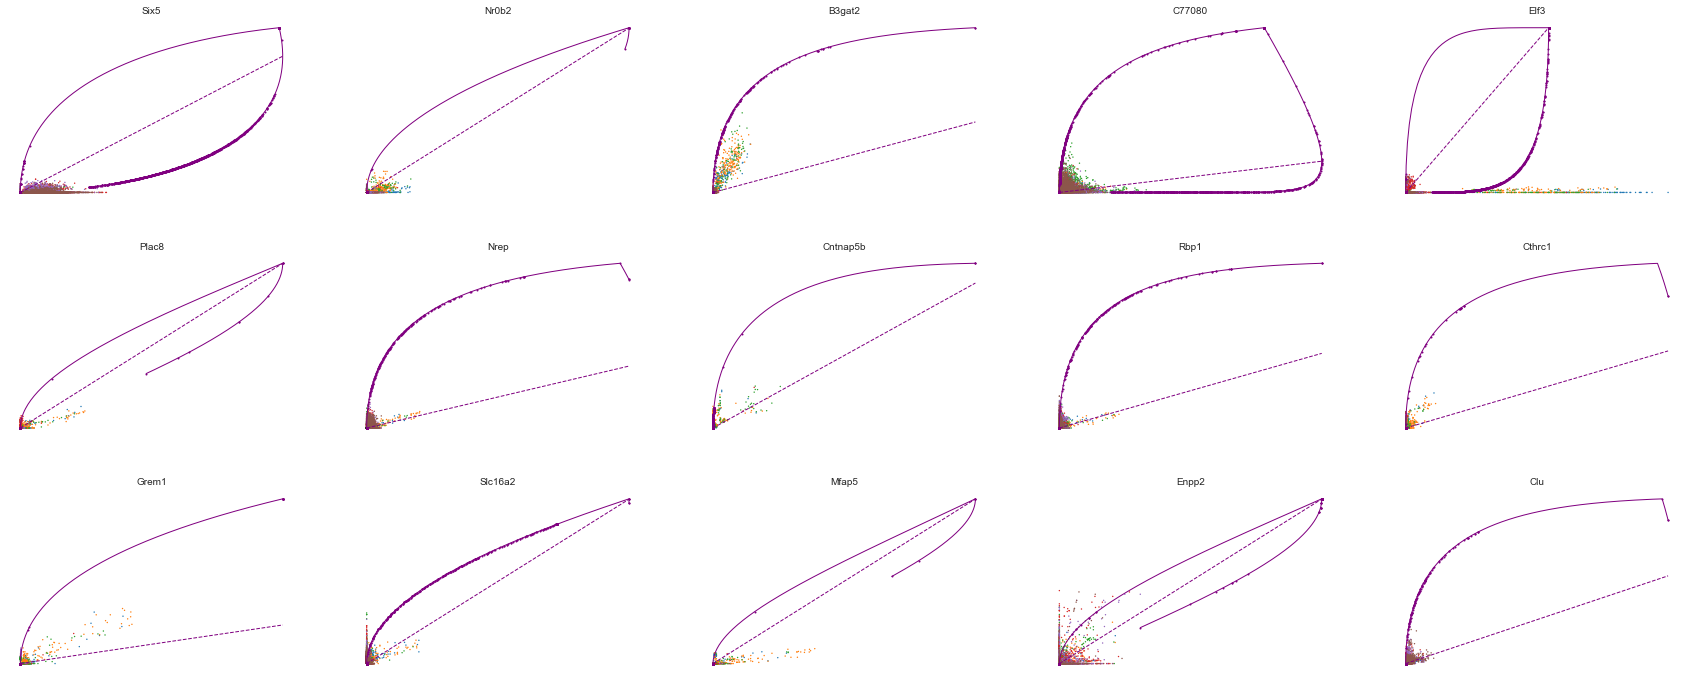

In [180]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False, color = 'timepoint')

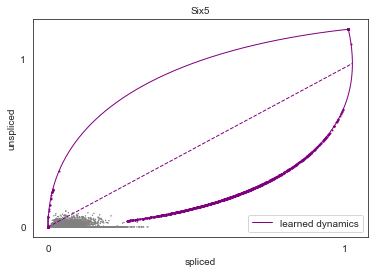

In [182]:
scv.pl.scatter(adata, basis = 'Six5', )